# Ön Bilgi
**Geliştiren :** Onur Kantar

**Veri Kümesinin İçeriği :** 3 farklı sınıfa ait toplamda 3000 tweet bulunmaktadır.

**Tweet Sınıfları :** 

-	Olumlu Tweetler
-	Olumsuz Tweetler
-	Nötr Tweetler

**Veri Kümesi Referansı :** "Eğiticili ve Geleneksel Terim Ağırlıklandırma Yöntemleriyle Duygu Analizi", Mahmut Çetin, M.Fatih Amasyalı, SIU 2013, KKTC

**Algoritma :** Decision Tree (DT)

**Ağ Mimarisi :** 


**batch_size :** 

**epochs :** 

**Doğruluk Oranı :** %100


---



In [1]:
import pandas as pd                     
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
tweets = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Sets/3000tweet.csv", sep=';', encoding="utf8")
tweets

,tweet,durum
0,dun Turkcelle tepkilerimizden sonra bugün Turk...,1
1,girmezmiyim.. Turkcell kartim bile var.. Yarin...,1
2,tam tünelden gecerken 3g cekiyordu :D türkcell...,1
3,turkcell superonline fiber internet veya ADSL ...,1
4,bence Gnçtrkcll Ark Winterfest 2012'de 1.olur ...,1
...,...,...
2995,Evet kesinlikle çok az.. Turkcell bu konuda şu...,3
2996,selocan nedir abicim ya ?,3
2997,özturkcell e dönücz diye korkuyorum ama çanakk...,3
2998,turkcell se 532 yi ara puk kodunu ogrenme menu...,3


# Veri Kümemizi Düzenleyelim : 

---



### NULL Değerleri Silme İşlemi : 

In [3]:
tweets.isnull().sum()

tweet    1
durum    0
dtype: int64

In [4]:
tweets = tweets.dropna().reset_index(drop=True)
tweets.isnull().sum()

tweet    0
durum    0
dtype: int64

### Gereksiz Kelimeleri - Boşukları - İşaretleri Silme İşlemleri :  

In [5]:
nltk.download('stopwords')
stop_word_list = stopwords.words('turkish')
stop_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [6]:
def preprocess_text(sen):
    
    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sen))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [7]:
x = tweets['tweet']
y = tweets['durum']

In [8]:
x = x.apply(preprocess_text)
pd.DataFrame(data=x)

,tweet
0,dun turkcelle tepkilerimizden sonra bugün turk...
1,girmezmiyim turkcell kartim bile var yarindan ...
2,tam tünelden gecerken cekiyordu türkcell in re...
3,turkcell superonline fiber internet adsl sabit...
4,bence gnçtrkcll ark winterfest olur gelir
...,...
2994,evet kesinlikle turkcell konuda an uygun değil...
2995,selocan nedir abicim
2996,özturkcell dönücz korkuyorum çanakkale holding...
2997,turkcell se yi ara puk kodunu ogrenme menusund...


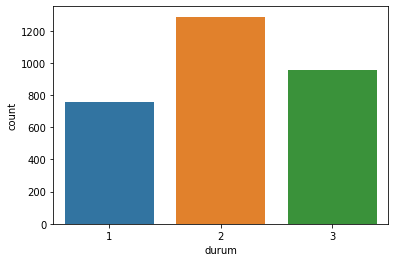

In [9]:
sns.countplot(y)

## Kelimeleri Sayılara Dönüştürelim : 

Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.


In [10]:
token = Tokenizer()
# Her kelimenin sıklığını hesaplar
token.fit_on_texts(x)
# Tüm kelimeleri sayı dizisine dönüştürür
x = token.texts_to_sequences(x)
# Bütün metinlerimiz en uzun kelimeden oluşan metnimiz kadar sütundan oluşan (23) bir dizi ile temsil edilecek.
# 23'den kısa metinlerin boşlukları 0'lar ile doldurulacak.
x = pad_sequences(x)

In [11]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
1031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,159,5,5757,5758,5759
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,390,83,70,151
2212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,333,3039,195
2214,0,0,0,0,3040,242,1232,9433,242,9434,12,12,9435,624,3007,773,1749,5,9436,1784,1,9437,9438
1797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8252,1525,604,8253,405,8254,86,8255


## X Verilerimizi Ölçeklendirelim : 

**Verileri Ölçeklendirme Nedir?**

Ölçeklendirme dediğimiz şey veri setindeki iki farklı özelliğin (değişkenin) değerlerini en doğru şekilde analiz edebilmemize olanak sağlayan bir yöntemdir.

- Verilerinizin dağılımının ortalama değeri 0 ve standart sapma değeri 1 olacak şekilde değiştiriyoruz (Standartlaştırma).
- Tutarlılık oluşuyor. Bir veri diğer verilerden daha büyükse diğerleri üzerinde egemenlik kurabilir. Bunu istemeyiz.
- Bir öğrenme modeliyle çalışırken, özellikleri sıfır merkezli bir aralığa ölçeklemek önemlidir.
- Değerleri karşılaştırmak yerine oranları karşılaştırmış oluruz.

**Örnek :**

İki farklı insan düşünelim. Bu insanların birisinin geliri ayda 5.000 Türk Lirası iken diğerinin geliri ayda 200.000 Türk Lirası olsun. Bu insanların ikisi de her ay belirli miktarda maddi yardım için maaşlarının bir kısmını ayırıyorlar. Diyelim ki 5.000 Türk Lirası maaşı olan şahıs 1.500 Türk Lirasını yardıma ayırıyorken, 200.000 Türk Lirası alan şahıs 10.000 Türk Lirasını yardım için ayırıyor.

Normal bir gözle bakarsak 10.000 Türk Lirası yardımda bulunan kişinin daha fazla yardım yaptığını görürüz. Fakat bunu oranladığımızda 5.000 Türk Lirası alan kişinin oransal olarak kat kat fazla yardım yaptığı anlaşılacaktır. İşte özellik ölçeklendirme ile biz bu özelliklerin sayısal değerlerinin birbirine yakın olmasını sağlayıp aralarındaki değerleri karşılaştırmak yerine oranları karşılaştırırız.

In [12]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [13]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
2633,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,-0.321374,-0.365379,-0.414129,-0.460660,-0.483752,-0.514478,-0.199134,2.862365,2.737697,-0.662745,-0.459297,-0.661076,-0.789953,-0.375592
1801,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,-0.310582,-0.364936,-0.402737,-0.432531,-0.165510,-0.500659,2.231456,-0.587962,1.995451,-0.169515,0.177377,-0.584695,-0.790512,-0.694279
2927,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,13.621329,0.451790,-0.222216,5.662995,5.329308,-0.362722,4.273124,-0.270600,0.653342,3.568188,-0.536575,3.162181,3.029079,2.858928,-0.661737,-0.506265,-0.597473,2.365118
665,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,-0.035406,-0.340579,1.504549,-0.335221,0.308430,-0.514123,-0.216006,-0.585679,-0.565471,-0.645938,-0.541907,-0.710533,-0.778220,-0.230861
197,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,1.457708,0.214311,-0.413722,-0.155804,0.823816,0.771410,0.668090,0.587485,-0.620006,-0.426826,0.400999,-0.622154,0.218821,0.168542


# Y Verilerimizi One Hot Encoding Uygulamamız Gerekiyor :  


---


**One Hot Encoding Nedir?**

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. Bu işlem, ağın model için problemi daha kolay hale getirmesine yardımcı olabilir. 


- Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.
- Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışındaki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [14]:
pd.DataFrame(y).sample(5)

,durum
1510,2
2335,3
1785,2
1649,2
2540,3


In [15]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
pd.DataFrame(y).sample(5)

,0
2248,2
1007,1
1394,1
741,0
519,0


In [16]:
y = to_categorical(y)
pd.DataFrame(y).sample(5)

,0,1,2
1485,0.0,1.0,0.0
2507,0.0,0.0,1.0
2248,0.0,0.0,1.0
62,1.0,0.0,0.0
2611,0.0,0.0,1.0


# Train ve Test İşlemleri İçin Ayrımı Gerçekleştirelim : 

---


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [18]:
print('x Train : ' + str(x_train.shape))
print('x Test : ' + str(x_test.shape))
print('y Train : ' + str(y_train.shape))
print('y Test : ' + str(y_test.shape))

x Train : (2399, 23)
x Test : (600, 23)
y Train : (2399, 3)
y Test : (600, 3)


# Eğitime Başlayalım

---


In [19]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [20]:
accuracy_score(y_test,model.predict(x_test))

0.905

# Sonuçları Değerlendirelim

---


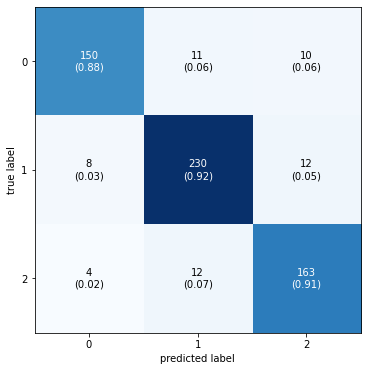

In [21]:
y_pred = model.predict(x_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

fig, ax = plot_confusion_matrix(conf_mat = cm,
                                show_normed = True,
                                figsize = (6,6))